In [1]:
from __future__ import division

from modules import * 
%matplotlib inline 

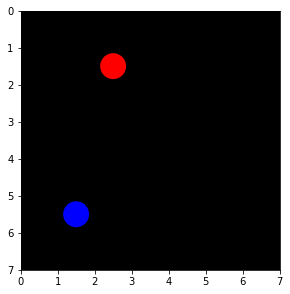

In [2]:
y_new = 7
x_new = 7
eu.height = y_new
eu.width = x_new
#make environment
maze = eu.gridworld([eu.height, eu.width],
                    rho        = eu.obs_rho,
                    num_pc     = eu.place_cells, 
                    pc_fwhm    = eu.fwhm, 
                    maze_type  = 'none', 
                    port_shift = eu.portshift)

#maze.rwd_loc.append((np.random.randint(x_new), np.random.randint(y_new)))
#maze.rwd_loc.append((np.random.randint(x_new), np.random.randint(y_new)))
#maze.rwd_loc.append((np.random.randint(x_new), np.random.randint(y_new)))

for i in maze.rwd_loc: 
    maze.orig_rwd_loc.append(i)
#show environment
eu.make_env_plots(maze,1,0)

## test out gridworld wrapper. 
env = eu.gymworld(maze)

In [3]:
# MF module parameters
dims = [env.observation_space.shape[0],env.action_space.n]
#use h1 =400
MF = mf.AC_Net(dims)
discount_factor = 0.98

#learning parameters
eta = 5e-4 #gradient descent learning rate
opt = mf.optim.Adam(MF.parameters(), lr = eta)

# EC module parameters
## memory limit should be ~75% of #actions x #states
EC = ec.ep_mem(MF,int(0.75*np.prod(maze.grid.shape)*env.action_space.n))
use_EC = False
#----------------
# Run Parameters
#----------------
#trial parameters
NUM_TRIALS = 7000
NUM_EVENTS = 300

In [4]:
print maze.rwd_loc
print use_EC


def make_OH(action):
    onehot = np.zeros(6)
    onehot[action] = 1
    return onehot

[(2, 1)]
False


In [18]:
# prime run parameters
EC.reset_cache()
reward = env.reward
timestamp = 0

# set up runtime, blocktime, print run started
# data frames for value and policy maps
val_maps = []
total_loss = [[],[]]
total_reward = []
print_freq = 1/10
check_EC_pols = []
rec_maps= False
#reset agent policy/value maps
value_map = maze.empty_map
# record current time before beginning of trial
print "Run started: ", time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())
runtime = time.time()
blocktime = time.time()
reward_tally = {}
for _ in maze.rwd_loc:
    reward_tally[_] = []
occ_list = []

rwd_threshold = True
trial_rwd_switch = 0
add_mem_dict = {}

track_policy_dict = {}

record_occupancy = False
track_confidence_score = [[],[]]
#==================================
# Run Trial
#==================================
EC.reward_unseen = True 
for trial in xrange(NUM_TRIALS):
    
    # prime trial
    state = Variable(torch.FloatTensor(env.reset()))
    reward_sum = 0
    v_last = 0
    reward_last = 0 
    trial_start = time.time()
    #if record_occupancy:
    #    occupancy = np.zeros((eu.height, eu.width))
    
    for event in xrange(NUM_EVENTS):
        #if record_occupancy:
        #    occupancy[maze.cur_state[1], maze.cur_state[0]] += 1
            
        
        # pass state through MF module
        policy_, value_ = MF(state)
        
        # pass state through EC module
        # get policy composed of MF and EC outputs
        if use_EC:
            add_mem_dict['state'] = maze.cur_state
            #policy_EC = EC.recall_mem(tuple(state.data[0]))
            #policy_ = EC.composite_policy(policy_, policy_EC,reward)
        
        choice, policy, value = mf.select_action_end(MF,policy_, value_)
        
        track_policy_dict[maze.cur_state] = policy, timestamp
        choice_prob = policy[choice]
        
        if event < NUM_EVENTS: 
            next_state, reward, done, info = env.step(choice)
        
        MF.rewards.append(reward)
                
        #compute eligibility trace/rpe approximation
        delta = reward_last + discount_factor*value - v_last
        
        if use_EC:
            #add event to memory cache
            
            add_mem_dict['activity'] = tuple(state.data[0])
            add_mem_dict['action'] = choice
            add_mem_dict['delta'] = delta
            add_mem_dict['timestamp'] = timestamp
            
            EC.add_mem(add_mem_dict,mixing=False)
        
        # update state
        state = Variable(torch.FloatTensor(next_state))
        
        ### is it supposed to be current state?? 
        reward_sum += reward
        reward_last = reward
        track_confidence_score[0].append(reward)
        track_confidence_score[1].append(EC.confidence_score)
        EC.compute_confidence(reward)
        
        v_last = value
        
        timestamp += 1
        
    if np.array(total_reward[-50:]).mean() > 260:
        if rwd_threshold:
            print " \t Started Memory at Trial ", trial
            maxsums = {}
            for item in reward_tally.items():
                maxsums[item[0]] = sum(item[1])
            most_rewarded_location = max(maxsums.iteritems(), key=operator.itemgetter(1))[0] 
            #maze.rwd_loc.remove(most_rewarded_location)
            #print "removed reward at ", most_rewarded_location
            rwd_threshold = False
            use_EC = True
            trial_rwd_switch = trial

            
    #if (trial_rwd_switch!=0) and (trial == trial_rwd_switch + 1000):
        #maze.rwd_loc.append(most_rewarded_location)
   
    #--- AT end of trial, update weights     
    value_map = mf.generate_values(maze,MF,None)
    if use_EC:
        policy_map = mf.generate_values(maze, MF, EC)
        rec_maps = True
        
    p_loss, v_loss = mf.finish_trial(MF, discount_factor,opt)
    total_loss[0].append(p_loss.data[0])
    total_loss[1].append(v_loss.data[0])
    total_reward.append(reward_sum)

    val_maps.append(value_map.copy())
    
    if rec_maps:
        check_EC_pols.append(policy_map.copy())
    for item in maze.reward_tally.items():
        reward_tally[item[0]].append(item[1])
    
    #if record_occupancy:
    #    occ_list.append(occupancy.copy())
    
    # print reward measure
    if trial%(print_freq*NUM_TRIALS)==0 or trial == NUM_TRIALS-1: 
        print "Trial {0} total reward = {1} (Avg {2:.3f})".format(trial, reward_sum, float(reward_sum)/float(NUM_EVENTS)), "Block took {0:.3f}".format(time.time()-blocktime)
        blocktime = time.time() 
    
print "Run took {0:.3f}".format(time.time()-runtime)

Run started:  Wed, 16 May 2018 15:43:55


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice.


Trial 0 total reward = 285 (Avg 0.950) Block took 0.347
 	 Started Memory at Trial  1


KeyboardInterrupt: 

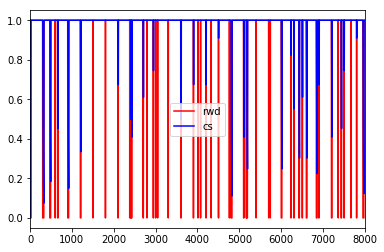

In [20]:
plt.figure()
plt.plot(track_confidence_score[0], 'r', label='rwd')
plt.plot(track_confidence_score[1], 'b', label='cs')
plt.legend(loc=0)
plt.xlim([0, 8000])

plt.show()
plt.close()

In [ ]:
plt.figure(0)
plt.plot(total_loss[0], label='ploss')
plt.plot(total_loss[1], label='vloss')
plt.legend(loc=0)

plt.figure(1)
plt.plot(total_reward, label='rwd')
plt.xlabel("Number of Trials")
plt.ylabel("Total Reward per Trial")
plt.axvline(x=trial_rwd_switch, color='r')
#plt.axvline(x=trial_rwd_switch+1000, color='r')

#plt.xlim([0,14000])
#plt.ylim([0,305])
#plt.legend(loc=0)
plt.show()

In [ ]:
plt.figure(0)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i,item in enumerate(maze.orig_rwd_loc):
    plt.plot(reward_tally[item],colours[i], label="Port{}".format(item), alpha = 0.5)
#plt.plot(reward_tally[1],'g', label="Port2", alpha = 0.5)
#plt.plot(reward_tally[2],'r', label="Port3", alpha = 0.5)
plt.legend(loc=0)
#plt.xlim([1700,2000])
#plt.ylim([0,50])
plt.show()
plt.close()

In [ ]:
eu.print_value_maps(maze,val_maps)
print maze.rwd_loc

In [ ]:
# policy maps in memory
import csv
test_frame = [(v[2],v[0], v[1],eu.softmax(v[0]), maze.actionlist[np.argmax(eu.softmax(v[0]))], [x for _,x in sorted(zip(eu.softmax(v[0]),maze.actionlist), reverse=True)]) for (k,v) in EC.cache_list.items()]

with open('mycsvfile.csv','wb') as f:
    w = csv.writer(f)
    w.writerows(test_frame)

resultant_frame = {}
for enum, i in enumerate(test_frame):
    resultant_frame[i[0]] = test_frame[enum][1:]


plt.figure()
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
cmap = plt.cm.Spectral_r
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cm.ScalarMappable(norm = cNorm, cmap=cmap)

for i in test_frame:
    state_loc = i[0]
    av = i[1]
    softmax = i[3] 
    
    ax[state_loc[1], state_loc[0]].cla()
    ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax)
    arg_ = np.argmax(softmax)
    if softmax[arg_] > 0.65:
        dx1,dy1,_,__ = eu.make_arrows(arg_, softmax[arg_])
        colorVal1 = scalarMap.to_rgba(softmax[arg_])
        ax[state_loc[1], state_loc[0]].arrow(5,.5,dx1,dy1,head_width =0.4, head_length =0.4, color=colorVal1)
    ax[state_loc[1], state_loc[0]].set_xticks([])
    ax[state_loc[1], state_loc[0]].set_yticks([])
    ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    if state_loc == maze.rwd_loc[0]:
        ax[state_loc[1], state_loc[0]].annotate('R', xy=(0,0.5), color='r')

plt.show()
plt.close()
    


In [ ]:
#print len(track_policy_dict.items())
#print track_policy_dict.keys()
plt.figure(figsize=(50,50))
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots(maze.grid.shape[0],  maze.grid.shape[1])
for i in track_policy_dict:
    y_dim = i[0]
    x_dim = i[1]
    ax[i[1], i[0]].bar(np.arange(6), np.array(track_policy_dict[i][0]), label= track_policy_dict[i][1], alpha = 0.5, color='b') #what was generated by network
    ax[i[1], i[0]].bar(np.arange(6)+0.25, resultant_frame[i][2], alpha=0.5, color='g')#comparable entry in memory
    ax[i[1], i[0]].set_xticks([])
    ax[i[1], i[0]].set_yticks([])
    ax[i[1], i[0]].set_ylim([-1,1])
    if i == maze.rwd_loc[0]:
        ax[i[1], i[0]].annotate('R', xy=(0,0.5), color='r')
plt.savefig('policies.svg', format='svg')
plt.show()
plt.close()

In [ ]:
plt.figure()
fig, ax = plt.subplots(maze.grid.shape[0], maze.grid.shape[1])
visits = np.zeros(maze.grid.shape)
time__ = np.zeros(maze.grid.shape)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in test_frame:
    state_loc = i[0]
    av = i[1]
    #time = i[2]
    softmax = i[3]
    
    if i[2] > time__[state_loc[1],state_loc[0]]:
        ax[state_loc[1], state_loc[0]].cla()
        ax[state_loc[1], state_loc[0]].bar(np.arange(6), softmax, label=time, alpha = .8, color = colours[int(visits[state_loc[1],state_loc[0]])])
        ax[state_loc[1], state_loc[0]].set_xticks([])
        ax[state_loc[1], state_loc[0]].set_yticks([])
        ax[state_loc[1], state_loc[0]].set_ylim([0,1])
    else:
        pass
    
    visits[state_loc[1],state_loc[0]] += 1
    time__[state_loc[1],state_loc[0]] = i[2]
    
plt.savefig('no_h_policies.svg',format='svg')
plt.show()
plt.close()
    


In [ ]:
inde = 0
plt.figure()
plt.pcolor(occ_list[inde], cmap="Spectral_r", vmin=0, vmax = 300)
plt.gca().invert_yaxis()
plt.axes().set_aspect('equal', 'datalim')
plt.colorbar()
plt.show()
plt.close()

In [ ]:
plt.close()
plt.figure()
eu.width = 5
eu.height = 5
for j, iterable in enumerate(check_EC_pols):
    if j < 25:
        fig, ax = plt.subplots(eu.width,eu.height)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()

    elif j % 10 == 0: 
        fig, ax = plt.subplots(eu.height,eu.width)
        axes = np.ravel(ax)
        data = np.ravel(check_EC_pols[j])
        for i, item in enumerate(axes): 
            item.bar(np.arange(6), list(data[i]))
            item.set_ylim([0,1])
            item.set_yticks([])
            item.set_xticks([])
        plt.savefig('pol_tests/pol_test{}.svg'.format(j), format='svg')
        plt.close()
#plt.show()